<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/ot_em.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
* develop expectation-maximization algorithm in cryoEM particles with optimal transport based loss
* extend Rao et al 2020 to EM

# Resources
* Rao, R., Moscovich, A., & Singer, A. (2020). Wasserstein K-Means for Clustering Tomographic Projections, (2016), 1–11.

# Setup

In [2]:
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
def doplt(arr2d):
  plt.imshow(arr2d,cmap='gray')
import numba
import pandas as pd


In [3]:
!pip install pot
import ot

     |████████████████████████████████| 430kB 13.5MB/s 


In [4]:
!pip install mrcfile
import mrcfile

     |████████████████████████████████| 51kB 5.6MB/s 


In [5]:
!pip install pyFFTW

     |████████████████████████████████| 2.6MB 16.9MB/s 


In [6]:
!rm twod.py
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/code/twod.py
!wget https://raw.githubusercontent.com/asarnow/pyem/master/pyem/mrc.py
import twod

rm: cannot remove 'twod.py': No such file or directory
--2021-01-16 16:35:48--  https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/code/twod.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14698 (14K) [text/plain]
Saving to: ‘twod.py’

twod.py             100%[===================>]  14.35K  --.-KB/s    in 0s      

2021-01-16 16:35:48 (106 MB/s) - ‘twod.py’ saved [14698/14698]

--2021-01-16 16:35:48--  https://raw.githubusercontent.com/asarnow/pyem/master/pyem/mrc.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1

In [7]:
def create_circular_mask(N, radius=None, center=None):
  # https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array
    h,w = N,N
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [8]:
@numba.jit
def make_C_from_pos(pos_flat):
  N2 = pos_flat.shape[0]
  C = np.empty((N2,N2))
  np.fill_diagonal(C,0)
  for i in range(C.shape[0]):
    for j in range(i,C.shape[1]):
      C[i,j] = np.sqrt(((pos_flat[i] - pos_flat[j])**2).sum())
      C[j,i] = C[i,j]

  return(C)

# Particle Data

In [ ]:
%%bash
wget ftp://ftp.wwpdb.org/pub/emdb/structures/EMD-7978/map/emd_7978.map.gz # sometimes this takes too long, and is completed but looks like it is still running

In [10]:
%%bash
gunzip emd_7978.map.gz  # do not put this in the same cell as wget... bc sometimes this takes too long, and is completed but looks like it is still running

In [11]:
f = mrcfile.open('emd_7978.map')
map = f.data
f.close()
N = map.shape[0]

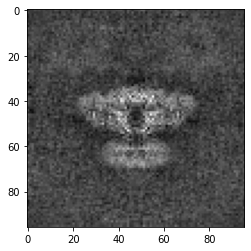

In [12]:
from scipy import ndimage
map_zoom = ndimage.zoom(map.sum(1),zoom=0.25)
doplt(map_zoom)

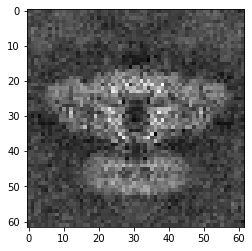

In [13]:
unpad_factor = .18
unpad = int(map_zoom.shape[0]*unpad_factor)
map_window = map_zoom[unpad:-unpad,unpad:-unpad]
doplt(map_window)

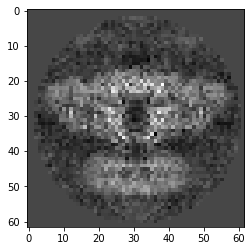

In [14]:
image = map_window.copy()
N = image.shape[0]
mask = create_circular_mask(N,radius=N/2.1)
image[~mask]=0
image /= image[mask].max()
doplt(image)

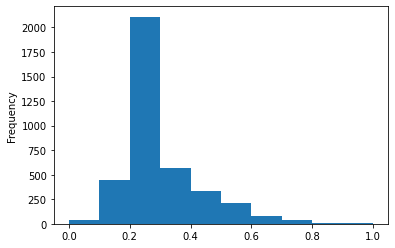

In [15]:
image -= image.min()
image /= image.max()
pd.Series(image.flatten()).plot.hist()

Perhaps negative values are problematic in the `ot` library.

# Cost

In [16]:
xv, yv = np.meshgrid(np.arange(N),np.arange(N), sparse=False, indexing='ij')
pos = np.dstack((xv, yv))
C = make_C_from_pos(pos[mask])
C /= C.max()

# Wp (parellelized)

We can take the L2 between X and A very quickly, since it just involces sums and squares, etc. Let's see if we can parallelize sinkhorn between X and the template library 

In [ ]:
sigma=.3
num_angles = 20
angles = np.linspace(0,180,num_angles)
A_align = np.zeros((N,N,num_angles))
noise = np.random.normal(loc=0*image,scale=sigma)
for angle_idx,angle in enumerate(angles):
  I1 = rotate(image,angle=angle/2,reshape=False) 
  A_align[:,:,angle_idx] = I1

A_align[~mask]=0
I1 = rotate(image,angle=-angle/2,reshape=False) + noise
I1_flat = I1[mask]
I1_flat /= I1_flat.max()
A_flat = A[mask]
A_flat /= A_flat.max(0)

In [ ]:
reg=0.5
%time ot.sinkhorn2(I1_flat,A_flat[:,0],C,reg=reg)
%time ot.sinkhorn2(I1_flat,A_flat[:,:2],C,reg=reg)
%time ot.sinkhorn2(I1_flat,A_flat[:,:5],C,reg=reg)
%time ot.sinkhorn2(I1_flat,A_flat[:,:10],C,reg=reg)
%time ot.sinkhorn2(I1_flat,A_flat,C,reg=reg)

CPU times: user 11.8 s, sys: 1.57 s, total: 13.3 s
Wall time: 6.86 s
CPU times: user 1min 8s, sys: 11.9 s, total: 1min 20s
Wall time: 44.8 s
CPU times: user 1min 44s, sys: 18.5 s, total: 2min 2s
Wall time: 1min 14s
CPU times: user 1min 59s, sys: 13.2 s, total: 2min 12s
Wall time: 1min 24s
CPU times: user 2min 33s, sys: 13.9 s, total: 2min 47s
Wall time: 1min 52s


array([0.19863469, 0.20251503, 0.20553518, 0.20767794, 0.21026819,
       0.21166108, 0.21258288, 0.21238214, 0.21108093, 0.20871401,
       0.20613975, 0.20205414, 0.19663816, 0.19122331, 0.18518145,
       0.17788134, 0.17053232, 0.16556964, 0.16194034, 0.16019225])

It takes about 6s to compute W, and we need to compute $n_\theta,n_x,n_y \sim 360/5*3*3-360/1*8*8 = 648-23040$, ie hundreds to tens of thousands$ 

`ot.sinkhorn2` uses some parallelization, so we get good speedups. Computing 20 Wps at box size 62 takes ~112s, so 648 Wps should take 1 hr. That's just for one particle!

Let's really push things and see how it scales.

In [ ]:
sigma=.01
num_angles = 10
reg=0.5
angles = np.linspace(0,180,num_angles)
A_align = np.zeros((N,N,num_angles))
noise = np.random.normal(loc=0*image,scale=sigma)
for angle_idx,angle in enumerate(angles):
  I1 = rotate(image,angle=angle/2,reshape=False) 
  A_align[:,:,angle_idx] = I1

A_align[~mask]=0
I1 = rotate(image,angle=-angle/2,reshape=False) + noise
I1_flat = I1[mask]
I1_flat /= I1_flat.max()
A_flat = A_align[mask]
A_flat /= A_flat.max(0)

#%time ot.sinkhorn2(I1_flat,A_flat,C,reg=reg)

In this case (for some reason) it was very fast. We'll have to do one particle at a time with `ot.sinkhorn2`. It should take 1.15 min (648/180*19.2/60) for 648 templates

In [ ]:
sigma=.3
num_angles = 648
angles = np.linspace(0,180,num_angles)
A = np.zeros((N,N,num_angles))
noise = np.random.normal(loc=0*image,scale=sigma)
for angle_idx,angle in enumerate(angles):
  I1 = rotate(image,angle=angle/2,reshape=False) 
  A[:,:,angle_idx] = I1

As[~mask]=0
I2 = rotate(image,angle=-angle/2,reshape=False) + noise
I1_flat = I1[mask]
I1_flat /= I1_flat.sum()
A_flat = A[mask]
A_flat /= A_flat.sum(0)

%time ot.sinkhorn2(I2_flat,A_flat,C,reg=reg)

CPU times: user 1min 14s, sys: 624 ms, total: 1min 14s
Wall time: 1min 8s


array([0.20343545, 0.20338007, 0.20335045, 0.20334331, 0.20335474,
       0.2033804 , 0.20341574, 0.20345609, 0.20349683, 0.20353351,
       0.20356191, 0.20357815, 0.20357873, 0.20356054, 0.20352091,
       0.20345789, 0.2033715 , 0.20326352, 0.20313687, 0.20299544,
       0.20284349, 0.20268494, 0.20252316, 0.202361  , 0.20220109,
       0.20204599, 0.2018983 , 0.20176068, 0.20163569, 0.20152562,
       0.20143184, 0.20135458, 0.20129294, 0.20124555, 0.20121093,
       0.2011869 , 0.20117118, 0.20116186, 0.20115747, 0.20115655,
       0.20115771, 0.20115939, 0.20115948, 0.20115543, 0.20114477,
       0.20112569, 0.20109687, 0.20105749, 0.20100726, 0.20094582,
       0.20087337, 0.20079058, 0.20069781, 0.20059562, 0.20048515,
       0.20036859, 0.20024932, 0.20013168, 0.20002013, 0.19991854,
       0.19983028, 0.19975786, 0.19970277, 0.19966523, 0.19964425,
       0.19963797, 0.19964446, 0.19966173, 0.19968756, 0.1997192 ,
       0.1997524 , 0.19978168, 0.19980176, 0.19980797, 0.19979

Yes! It only took 1.13min for 648 templates. Perhaps there can be further improvements, but we are getting in range, an EM iteration would take ~ N minutes if it had N particles. Let's add it in to EM.

# Wp in EM

## synthetic particles
choose noise level

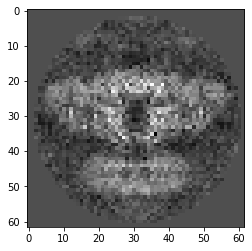

In [20]:
sigma=0.3
n_particles = 100
noise = np.random.normal(loc=np.zeros((n_particles, N,N)),scale=sigma)
noise[:,~mask] = 0
X = image + noise
deg_step=10
X_aligned = X.copy()
doplt(X_aligned.sum(0))


In [ ]:
pd.Series(image.flatten()).plot.hist()

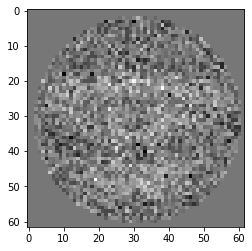

In [ ]:
doplt(X_aligned[0])

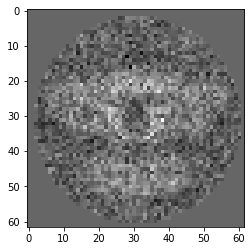

In [ ]:
doplt(X_aligned[-5:].sum(0))

Since the particles are going to represent histograms, let's scale them they are all positive values.

In [ ]:
rand_angles = deg_step*np.random.randint(low=0,high=360/deg_step,size=n_particles)

for angle_idx,angle in enumerate(rand_angles):
  X[angle_idx,:,:] = rotate(X[angle_idx,:,:],angle=angle,reshape=False) 

In [ ]:
np.unique(rand_angles)

array([ 50,  60,  80, 110, 150, 160, 190, 290, 320, 350])

For developing we'll just use a course grained angular grid, so we can only search in large angular steps and still recover the template

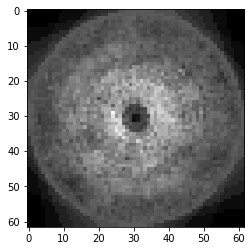

In [ ]:
doplt(X.sum(0))

In [ ]:
A_prev = X_aligned.sum(0)#blob#image.copy()

In [ ]:
A_next = A_prev.copy()
small_N = X.shape[0]
nx = X.shape[-1]
deg_step=10

# shifts_r = np.array([0])
# shifts_c = np.array([0])

angles = np.arange(0,360,deg_step)


## A library

In [ ]:
# A_align = np.zeros((nx,nx,angles.shape[0],shifts_r.shape[0],shifts_c.shape[0]))
A_align = np.zeros((nx,nx,angles.shape[0]))
# shift_r_idx,shift_c_idx = 0,0
for angle_idx,angle in enumerate(angles):
  #A_align[:,:,angle_idx,shift_r_idx,shift_c_idx] = rotate(A_prev,angle=angle,reshape=False) 
  A_align[:,:,angle_idx] = rotate(A_prev,angle=angle,reshape=False) 

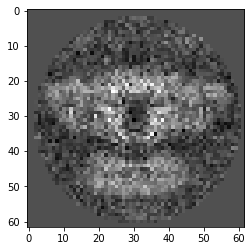

In [ ]:
doplt(A_align[:,:,0])

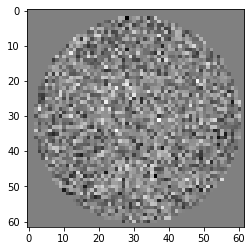

In [ ]:
doplt(X_aligned[1])

## Wp bayesian weights

C was precomputed

In [ ]:
i=0
x = X_aligned[i]
x_flat = x[mask]
x_flat /= x_flat.sum()
A_align_flat = A_align[mask]
A_align_flat /= A_align_flat.sum(0)
A_align_flat.shape

(2733, 36)

It.  |Err         
-------------------
    0|3.846364e-02|
CPU times: user 2.89 s, sys: 663 ms, total: 3.56 s
Wall time: 2.5 s


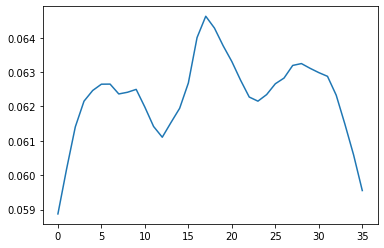

In [ ]:
%%time
reg=0.03
W, log = ot.sinkhorn2(x_flat,A_align_flat,C,reg=reg,method='sinkhorn',numItermax=3,stopThr=1e-5,verbose=True,log=True)
pd.Series(W).plot()

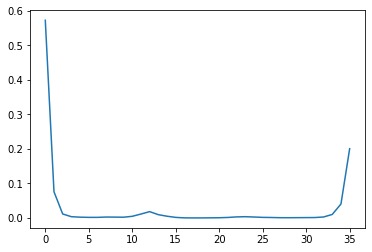

In [ ]:
#s=((A_prev - x)**2).sum()**.5 estimate in first pass?
arg = -W/(reg**2*2*sigma**2) # should be W with no power
g_W = np.exp(arg - arg.max(),dtype=np.float128) # more precision here in case many near zero
gi_stable = g_W
gi_stable /= gi_stable.sum()
pd.Series(gi_stable).plot()

## x aligned 
* could precompute for all X

In [ ]:
x_aligned = twod.comp_x_aligned(x,A_align.reshape(A_align.shape + (1,1,)),angles,np.array([0]),np.array([0]))
x_aligned = x_aligned.reshape(A_align.shape)

## update A

In [ ]:
A_next = np.zeros_like(A_prev)

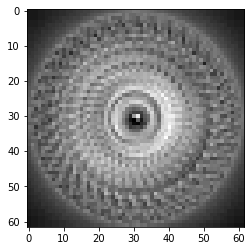

In [ ]:
gisum = gi_stable.sum()
Ui = 1/gisum
A_next += Ui*np.multiply(gi_stable.reshape((1,1,)+gi_stable.shape),x_aligned).sum(axis=(-1))
doplt(A_next)

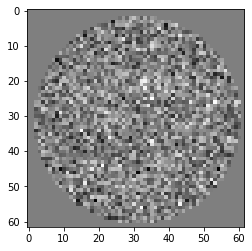

In [ ]:
doplt(x)

In [ ]:
rand_angles

array([110,  80,  50, 160, 350, 240, 330, 160, 100, 130,  40, 260, 290,
       340, 250,  10,   0, 310, 140, 210, 190, 130, 140, 280, 300,   0,
       150, 200, 160, 120, 310, 210, 320, 140,  10,  50,   0, 310,  40,
       130,   0, 330, 330,  60, 310,  30, 220, 310,  40, 250, 120, 220,
       300,  60,  80, 240, 200, 330,  30, 200, 140, 190, 270, 110,  30,
       160,   0, 280, 270, 190, 290,  20, 130, 330, 210,  60, 140, 110,
        10, 210, 170, 310, 130, 260,  20, 100, 130,  70, 340, 260, 280,
       120, 210, 100, 350, 150, 310,  30,  80, 250])

## EM

## blob

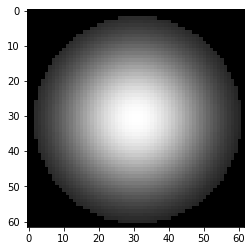

In [17]:
xv, yv = np.meshgrid(np.linspace(-1,1,N),np.linspace(-1,1,N), sparse=False, indexing='ij')
pos = np.dstack((xv, yv))

mux,muy=0,0
rv = multivariate_normal(mean=[0,0], cov=np.array([[1, 0], [0, 1]]))
blob = rv.pdf(2*pos+ np.array([mux,muy]))
blob[~mask]=0
doplt(blob)

In [18]:
timer = twod.timer
sum_ln_factorial = twod.sum_ln_factorial
shift_zeropad_axis = twod.shift_zeropad_axis
comp_x_aligned = twod.comp_x_aligned
comp_corr = twod.comp_corr

def do_2d_align(X,
  n_A_updates,
  A_prev=None,
  noise_param_d=None, #lam_k, sigma
  deg_step=None,
  shift_span=0,
  sigma_shift=np.inf,
  bool_circle_mask=None,
  do_plot=True,
  figsize=(16,32),
  do_log=False,
  do_time=False,
  X_aligned=None,
  A=None,
  stats='ot'):

  timer('starting initial setup',do_time)
  if A_prev is None: A_prev = X.mean(0)
  assert A_prev.shape == X.mean(0).shape
  A_next = A_prev.copy()

  small_N = X.shape[0]
  nx = X.shape[-1]

  # mask
  if bool_circle_mask is None:
    bool_circle_mask = ~cmask(index=(nx//2,nx//2),radius=int(nx//2*0.85),array=np.ones_like(A_prev)).astype(np.bool)

  # shifts
  shifts_r = np.arange(-shift_span,shift_span+1, dtype=np.int32)
  shifts_c = np.arange(-shift_span,shift_span+1, dtype=np.int32)
  if shift_span==0: 
    shifts_r = np.array([0])
    shifts_c = np.array([0])

  # angles
  angles = np.arange(1,360,deg_step)
  if deg_step is None:
    angles = np.array([0])

  # initialize
  A_align = np.zeros((nx,nx,angles.shape[0],shifts_r.shape[0],shifts_r.shape[0] ))
  x_aligned = np.zeros_like(A_align)
  best_X = np.zeros((n_A_updates,small_N,nx,nx))
  best_angles, best_shift_rs, best_shift_cs = np.zeros((n_A_updates,small_N)), np.zeros((n_A_updates,small_N)), np.zeros((n_A_updates,small_N))
  LL = np.zeros((n_A_updates,small_N))
  A_nexts = np.zeros((n_A_updates,) + A_next.shape)
  n_pixels = (~bool_circle_mask).sum() 
  gis = np.zeros((n_A_updates,small_N,angles.shape[0],1,1))

  if stats == 'gaussian':
    sigma = noise_param_d['sigma']
  elif stats == 'poisson':
    pass
  elif stats == 'ot':
    sigma = noise_param_d['sigma']
    reg = noise_param_d['reg']
    numItermax  = noise_param_d['numItermax']
    stopThr  = noise_param_d['stopThr']
    verbose  = noise_param_d['verbose']
    log  = noise_param_d['log']
    xv, yv = np.meshgrid(np.arange(nx),np.arange(nx), sparse=False, indexing='ij')
    pos = np.dstack((xv, yv))
    C = make_C_from_pos(pos[~bool_circle_mask])
    C /= C.max()

  X_bool = X.astype(dtype=np.bool)
  X_bool_circle_mask = np.logical_and(~bool_circle_mask,X_bool)

  extra_plot_n=4
  for obj in [A,X_aligned]:
    if obj is None: extra_plot_n -= 1

  if do_plot: 
    if n_A_updates == 1: 
      ncols=2
    else:
      ncols = n_A_updates
    fig, axes = plt.subplots(nrows=min(10,small_N)+extra_plot_n, ncols=ncols,figsize=figsize)

  for c in range(n_A_updates):
    timer('n_A_updates=%i'%c,do_time)
    
    ll=0
    A_prev = A_next.copy()
    A_next = np.zeros_like(A_prev)

    if do_plot: 
      axes[0,c].imshow(A_prev,cmap='gray') ; axes[0,c].set_axis_off()
      axes[0,c].set_title('A_prev')

    # reference alignments of template
    timer('reference alignments of template',do_time)
    for shift_r_idx, shift_r in enumerate(shifts_r):
      A_shift_r = shift_zeropad_axis(A_prev,shift=shift_r,axis=0)
      for shift_c_idx, shift_c in enumerate(shifts_c):
        A_shift_r_c = shift_zeropad_axis(A_shift_r,shift=shift_c,axis=1)
        for angle_idx, angle in enumerate(angles):
          A_shift_r_c[bool_circle_mask] = 0 # TODO test if interpolation different with windowing
          A_align[:,:,angle_idx,shift_r_idx,shift_c_idx] = rotate(A_shift_r_c,angle=angle, reshape=False)
    
    # terms that only depends on A
    timer('terms that only depends on A',do_time)
    if stats=='poisson':
      lam_k = noise_param_d['lam_k']
      negs = A_align[~bool_circle_mask][A_align[~bool_circle_mask] < 0]
      if negs.size < 0:
        negs = A_align[~bool_circle_mask][A_align[~bool_circle_mask] > 0].min() # hack to clip to smallest non zero value
      log_lam = np.log(A_align[~bool_circle_mask]+lam_k)
      # table of norms
      log_etolam = -(A_align[~bool_circle_mask].sum(axis=0)+(lam_k)*A_align[~bool_circle_mask].size) # the mask collapses the two xy image axes into one
    elif stats == 'gaussian':
      A_aligned_norm = np.linalg.norm(A_align[~bool_circle_mask],axis=0)
      A_aligned_norm_  = -(2*sigma**2)**-1*A_aligned_norm
    elif stats == 'ot':
      #A_align /= A_align[~bool_circle_mask].sum(0)
      A_align_flat = A_align.reshape(A_align.shape[:2]+(-1,))[~bool_circle_mask] # reshape to nx,nx,n_alignments
      A_align_flat /= A_align_flat.sum(0)

    else:
      assert False, 'only poisson and gaussian stats implemented'

    # pdf shifts, shift prior
    timer('pdf shifts, shift prior',do_time)
    log_prior_shift = np.zeros_like(A_align[0,0])
    for shift_r_idx in range(shifts_r.shape[0]):
      for shift_c_idx in range(shifts_c.shape[0]):
        q2 = shifts_r[shift_r_idx]**2+shifts_c[shift_c_idx]**2
        log_prior_shift[:,shift_r_idx,shift_c_idx] = -q2/(2*sigma_shift**2)

    r=0
    sigma_update = 0
    # TODO: vectorize over x (or chunk), for speed up
    for i in range(small_N):
      do_time_loop = do_time & (i % np.ceil(X[:small_N].shape[0]/10) == 0)
      timer('top of loop',do_time_loop)
      #print('image %i'%i)
      x = X[i]
          
      #Ki, gi
      timer('Ki, gi',do_time_loop)
      mask = X_bool_circle_mask[i]
      if stats == 'poisson':
        #log_lamtok = x[~bool_circle_mask].reshape(x[~bool_circle_mask].shape+(1,1,1,))*log_lam
        log_lam = np.log(A_align[mask]+lam_k) # new masking
        log_lamtok = x[mask].reshape(x[mask].shape+(1,1,1,))*log_lam
        log_gi_align = log_lamtok.sum(axis=0) + log_etolam + log_prior_shift

      elif stats == 'gaussian':
        newshape = x.shape + tuple(np.ones(A_align.ndim-2,dtype=np.int32))
        corr_A_x = comp_corr(A_align[mask],
          x[mask].reshape([-1,]+[1]*(A_align.ndim-2)),
          axis=0) # vectorized over alignment, axis 0 is pixels (flattened from bool_circle_mask)
        corr_A_x_ = sigma**-2*corr_A_x
        log_gi_align = A_aligned_norm_ + corr_A_x_ + log_prior_shift
      elif stats == 'ot':
        x_flat = x[~bool_circle_mask]
        x_flat /= x_flat.sum()
        W = ot.sinkhorn2(x_flat,A_align_flat,C,reg=reg,stopThr=stopThr,numItermax=numItermax,verbose=verbose,log=log)
        if log: W, log  = W
        log_gi_align = -W/(reg**2*2*sigma**2) # should be W with no power
      else:
        assert False, 'only poisson and gaussian stats implemented'
      
      Ki = log_gi_align.max()
      log_gi_align_stable = log_gi_align - Ki
      gi_stable = np.exp(log_gi_align_stable, dtype=np.float128) # more precision here in case many near zero
      gis[c,i] = gi_stable.reshape(gis.shape[2:])
      #if do_plot: r+=1 ; pd.Series(gi_stable).plot(ax=axes[r,c])

      timer('Ui',do_time_loop)
      # Ui
      gisum = gi_stable.sum()
      if not np.isclose(gisum, 0): 
        Ui = gisum**-1
        # log lik
        if np.isfinite(sigma_shift):
          log_sigma_shift = np.log(sigma_shift)
        else:
          log_sigma_shift = 0
        ll += -np.log(Ui) + Ki - sum_ln_factorial(x) -0.5*np.log(2*np.pi) - log_sigma_shift
      else: 
        Ui=0
      LL[c,i] = np.log(-ll)

      # update noise model
      timer('update noise model',do_time_loop)
      if stats == 'gaussian':
        #newshape = x.shape + tuple(np.ones(A_align.ndim-2,dtype=np.int32))
        diff  = np.subtract(A_align,x.reshape(newshape))
        errors = np.linalg.norm(diff[~bool_circle_mask],axis=0)**2
        sigma2_i = (gi_stable*errors).sum()
        sigma2_i /= gisum
        sigma2_i /= n_pixels
        sigma_update += np.sqrt(sigma2_i)

      # rev alignment
      timer('rev alignment',do_time_loop)
      x_aligned = comp_x_aligned(x,A_align,angles,shifts_r,shifts_c)

      # point estimate of best angle
      timer('point estimate of best angle',do_time_loop)
      if stats == 'ot': gi_stable = gi_stable.reshape(x_aligned.shape[2:]) # in case ot reshape
      angle_idx_best, shift_r_idx_best,shift_c_idx_best = np.unravel_index(np.argmax(gi_stable, axis=None), gi_stable.shape)
      best_angles[c,i] = angles[angle_idx_best]
      best_shift_rs[c,i] = shifts_r[shift_r_idx_best]
      best_shift_cs[c,i] = shifts_c[shift_c_idx_best]
      best_X[c,i,:,:] = x_aligned[:,:,angle_idx_best,shift_r_idx_best,shift_c_idx_best]

      # Maximization (update A)
      timer('Maximization (update A)',do_time_loop)
      A_next += Ui*np.multiply(gi_stable.reshape((1,1,)+gi_stable.shape),x_aligned).sum(axis=(-1,-2,-3))

      timer('print',do_time_loop)
      if i % np.ceil(X[:small_N].shape[0]/10) == 0: 
        if do_log: print('i = %i, ll = %.2f, A_next min=%.2f, max=%.2f' % (i,ll,A_next[~bool_circle_mask].min(),A_next[~bool_circle_mask].max()))
        if stats == 'gaussian':
          if do_log: print('sigma_i',np.sqrt(sigma2_i))
        if do_plot: 
          axes[r+1,c].imshow(A_next,cmap='gray')
          axes[r+1,c].set_axis_off()
          axes[r+1,c].set_title('A_next')
          r+=1
      timer('end of loop',do_time_loop)


    timer('finish')
    A_next /= small_N
    A_nexts[c] = A_next
    if stats == 'gaussian': 
      sigma_update /= small_N
      if do_log: print('sigma_update',sigma_update)
      if noise_param_d['do_update_sigma']: sigma = sigma_update

    if do_plot: 
      r+=1 ; axes[r,c].imshow(X[:small_N].mean(0),cmap='gray') ; axes[r,c].set_axis_off() ; axes[r,c].set_title('X mean')
      if X_aligned is not None: 
        r+=1; axes[r,c].imshow(X_aligned[:small_N].mean(0),cmap='gray') ; axes[r,c].set_axis_off() ; axes[r,c].set_title('X_aligned mean')
      if A is not None:
        r+=1 ; axes[r,c].imshow(A,cmap='gray') ; axes[r,c].set_axis_off() ; axes[r,c].set_title('A')

  return(A_nexts,gis)

## OT

i = 0, ll = -483.54, A_next min=-0.04, max=0.77
i = 2, ll = -1453.06, A_next min=0.13, max=2.28
i = 4, ll = -2396.33, A_next min=0.27, max=3.78
i = 6, ll = -3376.02, A_next min=0.53, max=5.08
i = 8, ll = -4330.17, A_next min=0.39, max=6.43
i = 10, ll = -5294.86, A_next min=0.52, max=7.83
i = 12, ll = -6259.75, A_next min=0.43, max=9.10
i = 14, ll = -7216.29, A_next min=0.45, max=10.68
i = 16, ll = -8176.42, A_next min=0.40, max=12.02
i = 18, ll = -9125.33, A_next min=0.59, max=13.47
21:09:31:444 finish
i = 0, ll = -431.93, A_next min=-0.48, max=1.16
i = 2, ll = -1297.23, A_next min=-0.54, max=3.08
i = 4, ll = -2143.11, A_next min=-0.33, max=5.04
i = 6, ll = -3026.45, A_next min=-0.23, max=6.81
i = 8, ll = -3875.91, A_next min=-0.04, max=8.44
i = 10, ll = -4735.00, A_next min=0.27, max=10.32
i = 12, ll = -5603.45, A_next min=0.14, max=11.74
i = 14, ll = -6458.27, A_next min=0.32, max=13.57
i = 16, ll = -7314.12, A_next min=0.21, max=14.96
i = 18, ll = -8154.70, A_next min=0.39, max=16.5

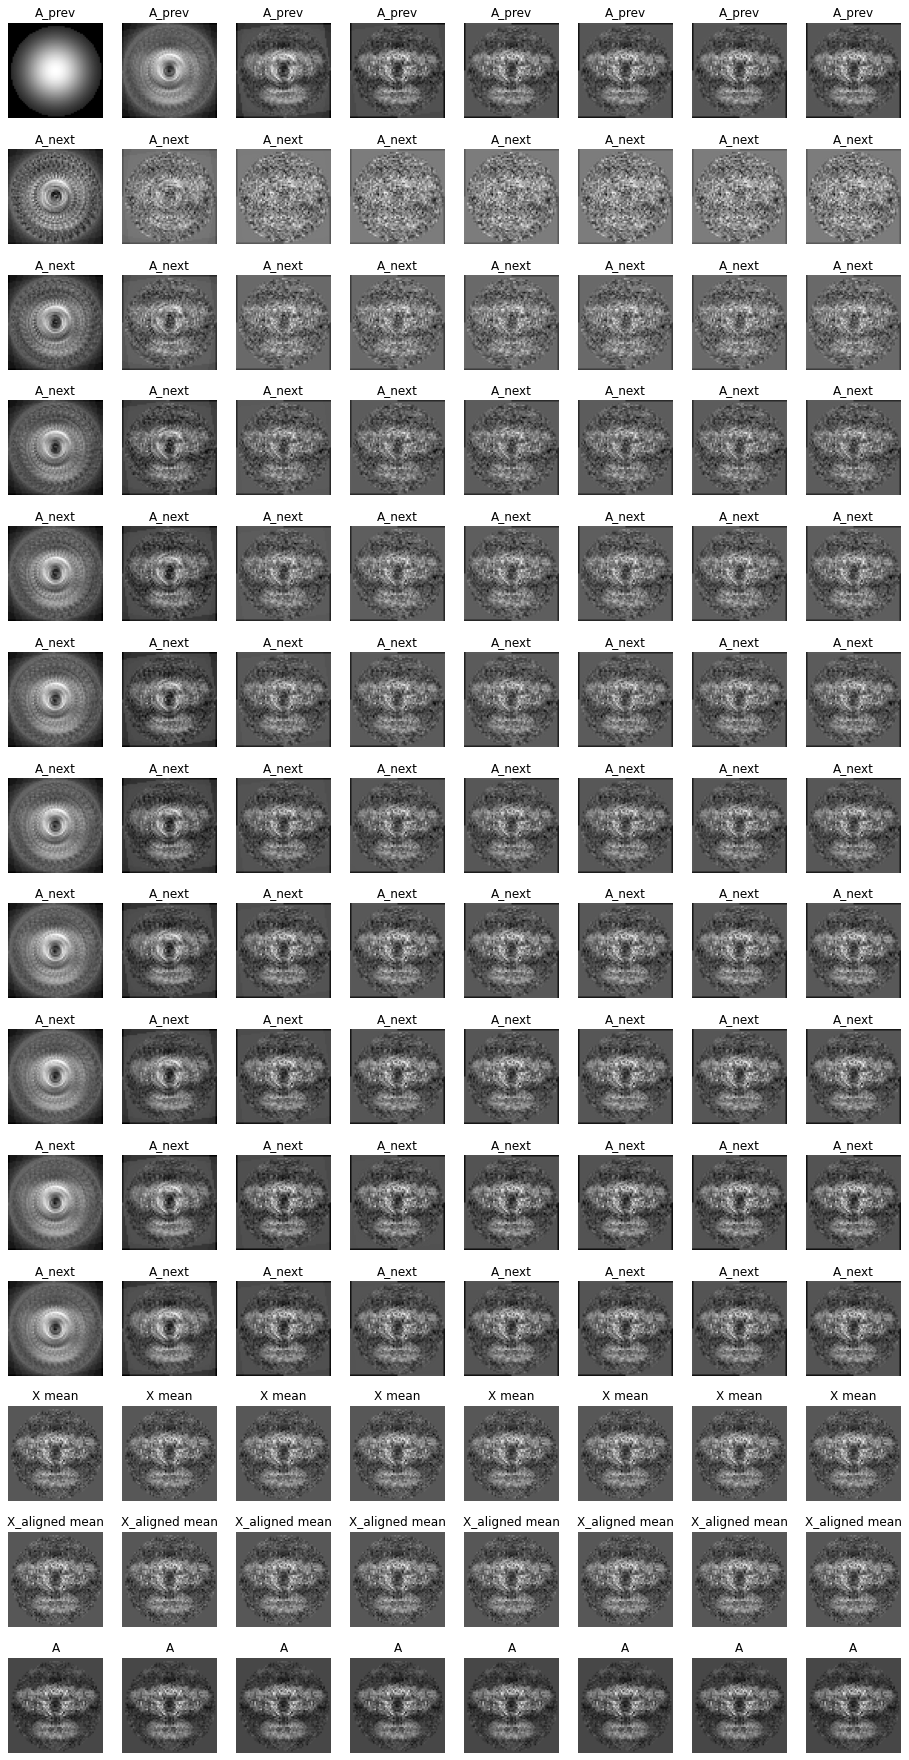

In [334]:

A_nexts, gis = do_2d_align(X=X_aligned[:20],
  n_A_updates=8,
  A_prev=blob,
  noise_param_d={'reg':0.03,'numItermax':5,'stopThr':1e-5,'verbose':False,'log':False,'sigma':sigma,'do_update_sigma':False}, #lam_k, sigma
  deg_step=10,
  shift_span=0,
  sigma_shift=np.inf,
  bool_circle_mask=~mask,
  do_plot=True,
  figsize=(16,32),
  do_log=True,
  do_time=False,
  X_aligned=X_aligned,
  A=image,
  stats='ot')

|snr|init template|num pt|reg|stopThr|numIttmax|# itt to get good 2d class|notes|
|-|-|-|-|-|-|-|-|
|0.3|blob|20|0.06|1e-5|50|5-6|still a bit choppy template from deg gridding in final itt|
|0.3|blob|20|0.03|1e-5|50|2|dramatic improvement with reg factor of 2 smaller|
|0.3|blob|20|0.06|1e-5|50|5-8+|even at 8 rounds, still choppy|
|0.3|blob|20|0.06|1e-5|5|?|very small numItermax for fast, good after 2itt, even better after 3-4. maxes out after 4 itt|

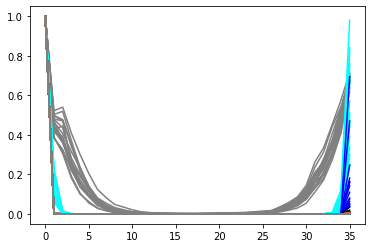

In [335]:
colors = ['gray','cyan','blue','black','magenta','red','orange']
colors = colors + colors
for c in range(gis.shape[0]):
  for i in range(gis.shape[1]):
    pd.Series(gis[c,i,:,0,0]).plot(color=colors[c])

We can see the bayes factors are smooth and farily peaked in the first iteration noisy

## Gaussian

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:190: RuntimeWarning: invalid value encountered in log


16:59:12:160 finish
16:59:12:844 finish
16:59:13:533 finish
16:59:14:225 finish
16:59:14:920 finish
16:59:15:604 finish


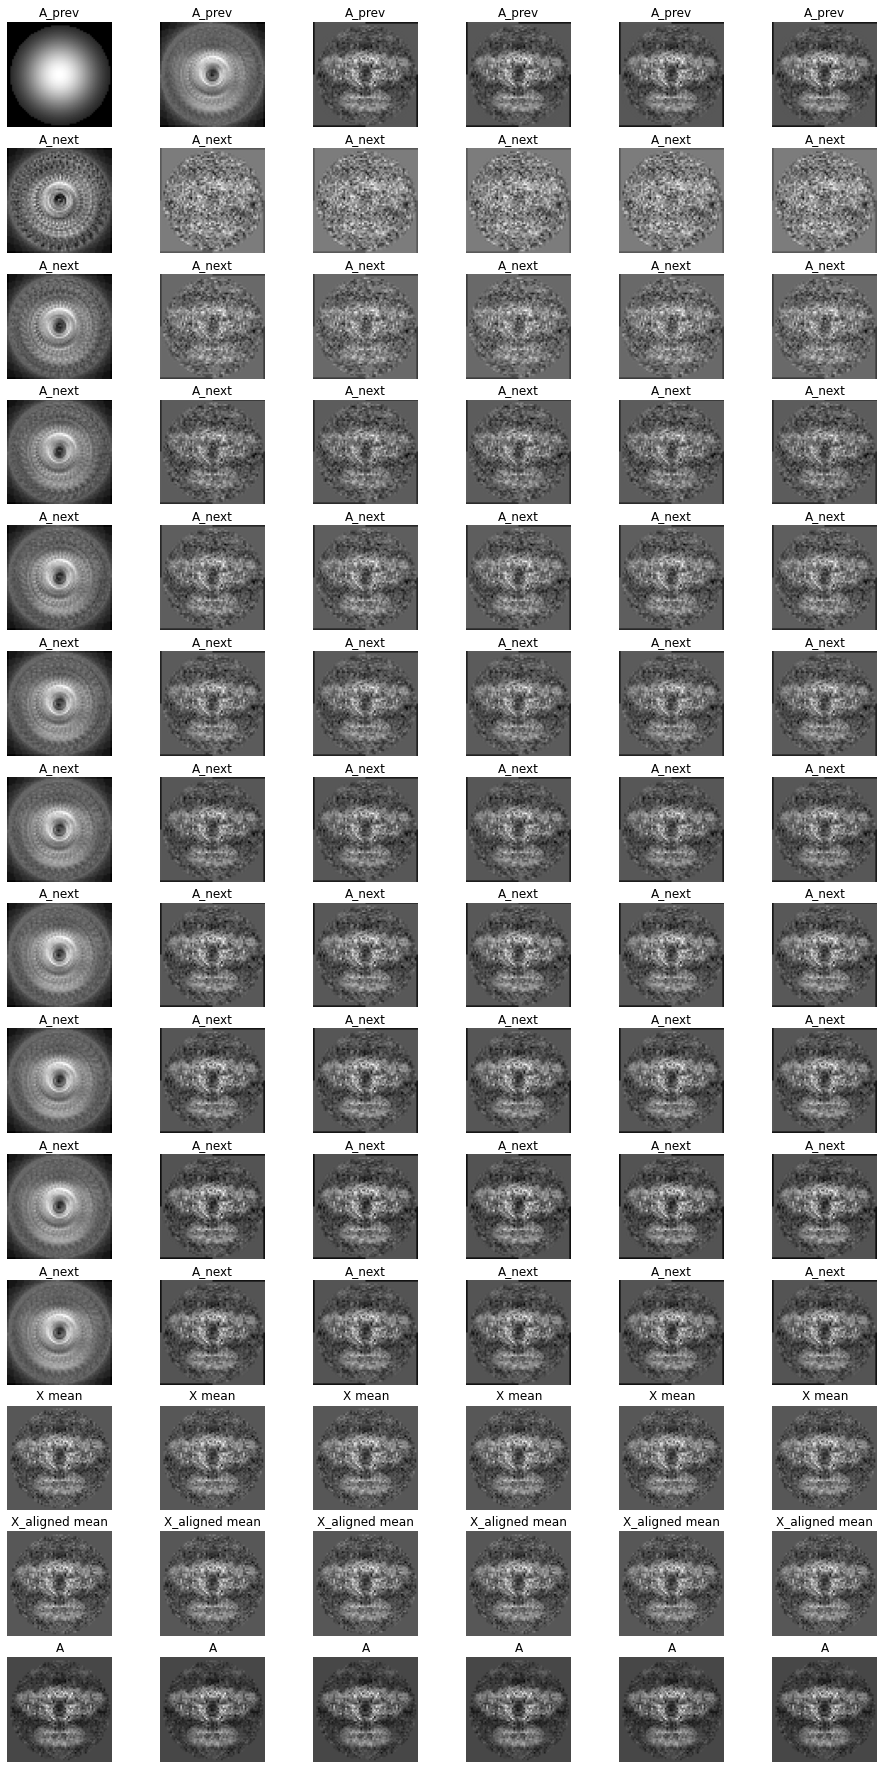

In [23]:
A_nexts, gis = do_2d_align(X=X_aligned[:20],
  n_A_updates=6,
  A_prev=blob,
  noise_param_d={'sigma':sigma,'do_update_sigma':True}, #lam_k, sigma
  deg_step=10,
  shift_span=0,
  sigma_shift=np.inf,
  bool_circle_mask=~mask,
  do_plot=True,
  figsize=(16,32),
  do_log=False,
  do_time=False,
  X_aligned=X_aligned,
  A=image,
  stats='gaussian')

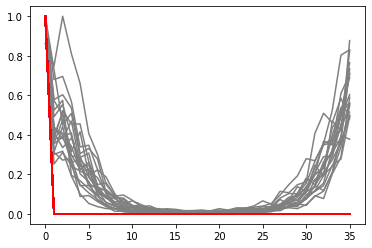

In [25]:
colors = ['gray','cyan','blue','black','magenta','red','orange']
for c in range(gis.shape[0]):
  for i in range(gis.shape[1]):
    pd.Series(gis[c,i,:,0,0]).plot(color=colors[c])

We can see the bayes factors are more noisy

# sinkhorn

The bottle neck in the OT treatment is computing W. Let's try to compute it ourselves, parallelizing it. We can check when the runtime and memory bottlenecks are and think about how to overcome them.

* see [ot.sinkhorn2](https://github.com/PythonOT/POT/blob/f6139428e70ce964de3bef703ef13aa701a83620/ot/bregman.py#L269)

In [ ]:
%%time
a = X_aligned[0][mask]
a /= a.sum()
b = A_align[mask]
b /= b.sum()
M=C
dim_a = len(a)
dim_b = len(b) # just first axis
n_hists = b.shape[1]

early_check = [3,5]

u = np.ones((dim_a, n_hists)) / dim_a
v = np.ones((dim_b, n_hists)) / dim_b

reg=0.1
# Next 3 lines equivalent to K= np.exp(-M/reg), but faster to compute
K = np.empty(M.shape, dtype=M.dtype) # factor out
np.divide(M, -reg, out=K) # factor out
np.exp(K, out=K) # factor out
tmp2 = np.empty(b.shape, dtype=M.dtype) # factor out
Kp = (1 / a).reshape(-1, 1) * K # row mult, check Kp[0]*a[0] 

cpt = 0
err = 1
stopThr=1e-9
numItermax=1000
while (err > stopThr and cpt < numItermax):
  
  twod.timer('cpt %i'%cpt)
  # twod.timer('first dot prods')
  uprev = u
  vprev = v
  KtransposeU = np.dot(K.T, u) # shape a.shape[0], b.shape[1]. is n_pixels, n_alignments
  v = np.divide(b, KtransposeU) # updated v. same shape as b
  u = 1. / np.dot(Kp, v) # updates u, same shape as b
  # twod.timer('first dot prods')

  # twod.timer('check num err')
  if (np.any(KtransposeU == 0) # 0.001 sec
          or np.any(np.isnan(u)) or np.any(np.isnan(v))
          or np.any(np.isinf(u)) or np.any(np.isinf(v))):
      # we have reached the machine precision
      # come back to previous solution and quit loop
      # print('Warning: numerical errors at iteration', cpt)
      u = uprev
      v = vprev
      break
  #twod.timer('check num err')
  if (cpt % 10 == 0) or cpt in early_check :
    twod.timer('comp b')
    np.einsum('ik,ij,jk->jk', u, K, v, out=tmp2) # 0.87 sec
    twod.timer('comp b')

    twod.timer('check b conv')
    err = np.linalg.norm(tmp2 - b) # 0.001 sec
    twod.timer('check b conv: %.2f'%err)
    #res = np.einsum('ik,ij,jk,ij->k', u, K, v, M)
    # print(cpt)
    # print(err)
    # print(res)

  cpt = cpt + 1

twod.timer('comp res')
res = np.einsum('ik,ij,jk,ij->k', u, K, v, M) # 1.39s
twod.timer('comp res')

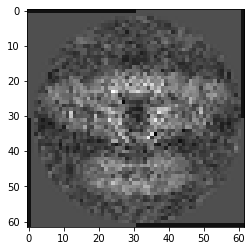

In [ ]:
doplt(A_align[:,:,0])

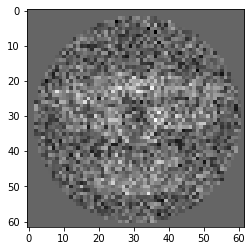

In [ ]:
doplt(X_aligned[-1])

# Forward model
Thus far we have used gaussian additive noise as a forward model. But it's not clear how OT fits into this. What probability are we maximizing in the Bayesian setting? What is the physical model assiciated with this probability?

Let's start with transport, and simulate data where pixel intensities are being transported. Hopefully we can work forwards with this, and backwards with the Bayes factors, and meet in the middle. Doing so can allow, perhaps, for the right reg to be estimated from the data.

Simulated data approach: monte carlo

-  Reshape 2D image into 1D
- Compute cost matrix, reshape into 1D
- transform cost matrix to probability matrix (absolute scaling is important here, also introduce entropy as prior?)
- sample by MC
- normalize rows to get "permuation matrix", $P_{erm}$, where intensity values are real values and can split up
- compute the transport matrix (not necessarily optimal!)
  - T=$diag(A)P_{erm}$
  - columns sum to the new pixel values in the sampled image
- reshape 1D vector into 2D image

We can play with the reg value, $\epsilon$, to get images that by eye look like they have enough noise.


In [31]:
image_1d = image.flatten()

In [297]:
xv, yv = np.meshgrid(np.arange(N),np.arange(N), sparse=False, indexing='ij')
pos = np.dstack((xv, yv))
C = make_C_from_pos(pos.reshape(-1,2))
C_max_save=C.max()


Note that we did not normalize C here.

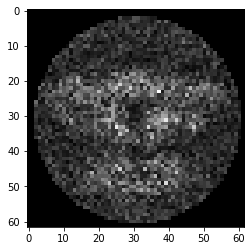

In [290]:
def sample_mc_precomp(C,reg):
    Prob = np.exp(-C/reg) # absolute value matters here, also entropy prior with reg value?
    return(Prob)
def sample_mc(image_1d,Prob,mask):
  Uni = np.random.uniform(low=0,high=1,size=Prob.size).reshape(Prob.shape) # for one sample / simulated particle
  Perm = Prob > Uni
  T = np.multiply(image_1d.reshape(-1,1),  Perm )# ensure shape
  x_sample = T.sum(0).reshape(N,N)
  x_sample[~mask]=0
  return(x_sample)

reg=.75
Prob = sample_mc_precomp(C,reg=reg)
x_sample = sample_mc(image_1d,Prob,mask)
doplt(x_sample)

In [291]:
n_samples=500
X_ot = np.zeros((n_samples,N,N))

Prob = sample_mc_precomp(C,reg=reg)

for i in range(n_samples):
  if i % (n_samples//10) == 0: print(i)
  X_ot[i] = sample_mc(image_1d,Prob,mask)

0
50
100
150
200
250
300
350
400
450


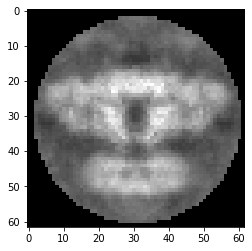

In [292]:
doplt(X_ot.mean(0))

The averaged image of 100 particles is still blurry. What would it look like if we averaged together infinite particles? Since know the data generating process, we can just compute it. It will be blurring, with the probabilities coming from the probability matrix (no uniform sampling, just contributions from nearby pixels weighted by their distance from the cost matrix). So we simply convolute with a distance kernel

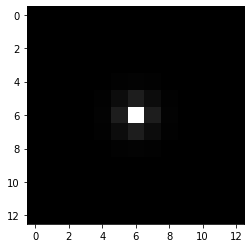

In [328]:
k=13
reg=.03
sigma=.3
assert k%2 != 0
distance_kernel = np.zeros((k,k))
for i in range(k):
  for j in range(k):
    centre=(k-1)/2
    distance_kernel[i,j] = np.sqrt(((i-centre)**2+(j-centre)**2))
gi = np.exp(-.03*distance_kernel/(reg**2*2*C_max_save*sigma**2)) # bayes factor
doplt(gi)

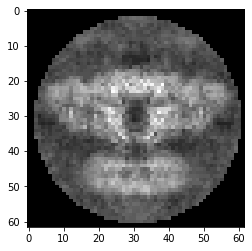

In [329]:
from scipy.signal import convolve2d
blur = convolve2d(image,gi,mode='same')
blur[~mask]=0
doplt(blur)

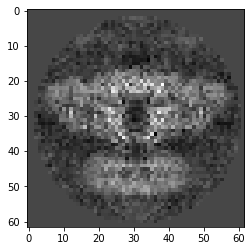

In [181]:
doplt(image) # the best we can do (starting template)

We see that even with particles that are very blurred out (from transport), we can recover some details, if we have enough particles. However, with this forward model there is a limit as to how well we can do, depending on the reg param. There is always some blurring that happens in our forward model in a way that depends on the probability kernel / mc sampling.

In practice, a good 2D classes with structural features can have 100-4000  particles.

We can choose the reg param like so
1. choose a reg
2. blur out idealized template
3. this blured template is an upper bound. if you had infinite samples, the 2D class from perfectly aligned particles would look like the result from 2. 

Next steps:

The optimal transport distance is $W=\sum_{i,j} \gamma_{ij}M_{ij} + \lambda\gamma_{ij}\ln\gamma_{ij}$
  * the reg param is $\lambda$
  * the transport plan is $\gamma$
  * the cost is $M$
  * the indeces $(ij)$ are from 2d pixel coordinate i $(x_i,y_i)$ to 2d pixel coordinate j $(x_j,y_j)$
  * each particle and template has its own W. When a particle is aligned to a template library there as many bayes factors as templates in the library (rotations, shifts, etc).
  * if the Bayes factors are $e^{-W}$, where does the reg come in?

Perhaps we should simulate data according not only to the cost matrix $M$, but also the prior. Ie, we somehow use the value of $\lambda$ to change how the monte carlo sampling works.

How to work in the regularization paraaeter? Perhaps simulate a transport plan probabilistically from the cost matrix, then do monte carlo sampling to generate a single sample of the particle (ie a synthetic particle), and then use the reg param as an acceptance criterion. If the transport plan has too much entropy, then the entropy contribution to W would be too large, and we reject it.